In [3]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2

from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


#### Experiment #1 : HandCrafted AntiSymmetric Bipolar Convolution


In [4]:
k = 20 # Top 10% highest l2-magnitude filters

In [5]:
F = 0

filters = np.zeros((3,3,1,1))

t = np.zeros((3,3))
t[1, 0] = np.sqrt(0.25)
t[0, 0] = np.sqrt(0.75)
filters = np.reshape(fft.idctn(t, norm='ortho'), (3,3,1,1)) 
filters /= np.sum(np.abs(filters))

#filters[:,:,0,0] =  (1/9)*np.array([[1,1,1], [1,1,1], [1,1,1]]) + (1/6)*np.array([[1,1,1], [0,0,0], [-1,-1,-1]]) 


theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)

a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])
mag = reduce_euclidean_norm(filters, axis=[0,1])


x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()
y =( a_mag[:,F]*np.sin((theta[:,F]))).numpy()
z =(s_mag[:,F]*np.sign(np.mean(s, axis=(0,1)))[:,F]).numpy()
plt.rcParams.update({'figure.dpi': '100'})




(3, 3, 1, 1)
(1, 3, 3, 1) (1, 3, 3, 1) (1, 3, 3, 1)


In [6]:
#var = 2/(128*9)

img =  cv2.imread('input4.png', 0)/255. 
#img = (img-np.mean(img))/np.std(img)
#img = tf.repeat(tf.expand_dims([img], axis=-1) , repeats = 512, axis=-1)  #get_double_slit(shape) , axis=0)
print(img.shape)

(224, 224)


In [7]:
np.var(img), 1/(128*9)


(0.023040123255935026, 0.0008680555555555555)

(3, 3, 1, 1)
0
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(0.0, shape=(), dtype=float32) 11.015031
(1, 224, 224, 1)


1
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(0.4735185, shape=(), dtype=float32) 11.035368
(1, 224, 224, 1)
2
(1, 224, 224, 1)
VALS 0.99999994
tf.Tensor(0.94703686, shape=(), dtype=float32) 11.055667
(1, 224, 224, 1)
3
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(1.4205555, shape=(), dtype=float32) 11.075929
(1, 224, 224, 1)
4
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(1.8940735, shape=(), dtype=float32) 11.096155
(1, 224, 224, 1)
5
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(2.3675919, shape=(), dtype=float32) 11.116343
(1, 224, 224, 1)
6
(1, 224, 224, 1)
VALS 0.99999994
tf.Tensor(2.8411102, shape=(), dtype=float32) 11.135769
(1, 224, 224, 1)
7
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(3.3146288, shape=(), dtype=float32) 11.154436
(1, 224, 224, 1)
8
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(3.7881474, shape=(), dtype=float32) 11.172347
(1, 224, 224, 1)
9
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(4.261666, shape=(), dtype=float32) 11.1895895
(1, 224, 224, 1)
10
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(4.7351837, shape=(), dtype=float32) 1

c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(1, 224, 224, 1)
VALS 0.99999994
tf.Tensor(9.470367, shape=(), dtype=float32) 11.353111
(1, 224, 224, 1)
21
(1, 224, 224, 1)
VALS 1.0000001
tf.Tensor(9.943888, shape=(), dtype=float32) 11.366613
(1, 224, 224, 1)
22
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(10.417405, shape=(), dtype=float32) 11.379987
(1, 224, 224, 1)
23
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(10.8909235, shape=(), dtype=float32) 11.393247
(1, 224, 224, 1)
24
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(11.364442, shape=(), dtype=float32) 11.406408
(1, 224, 224, 1)
25
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(11.837959, shape=(), dtype=float32) 11.41948
(1, 224, 224, 1)
26
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(12.31148, shape=(), dtype=float32) 11.432475
(1, 224, 224, 1)
27
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(12.784998, shape=(), dtype=float32) 11.4454
(1, 224, 224, 1)
28
(1, 224, 224, 1)
VALS 1.0
tf.Tensor(13.258516, shape=(), dtype=float32) 11.458264
(1, 224, 224, 1)
29
(1, 224, 224, 1)
VALS 0.9999999
tf.Tensor(13.732032, shape=(), dtype=float

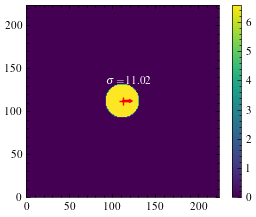

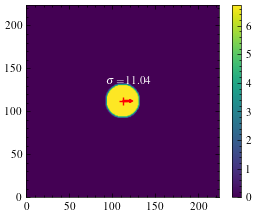

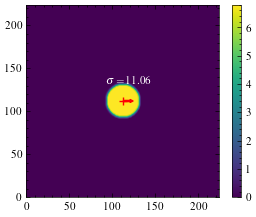

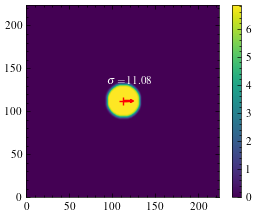

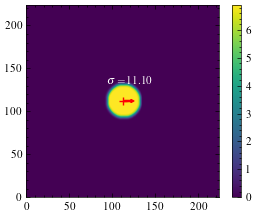

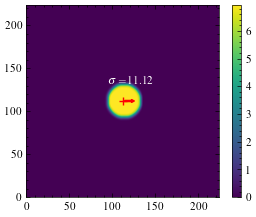

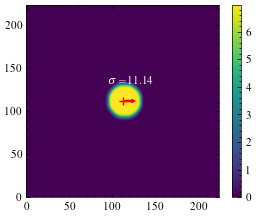

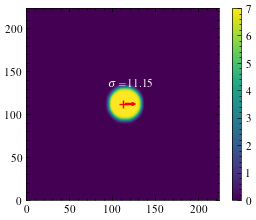

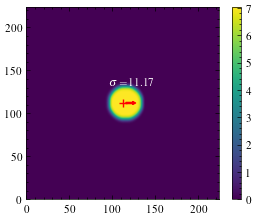

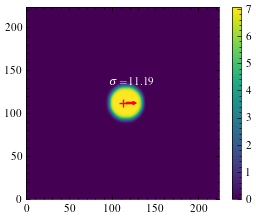

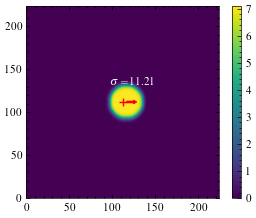

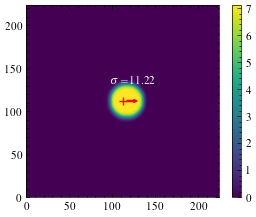

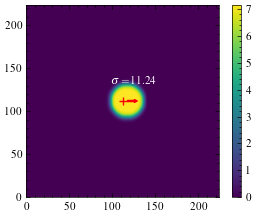

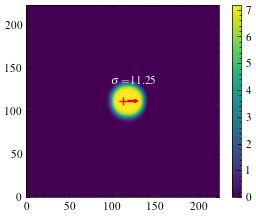

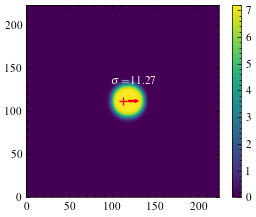

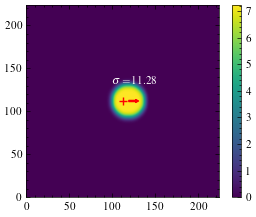

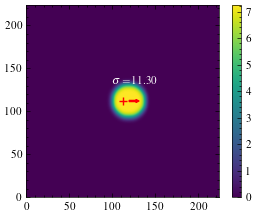

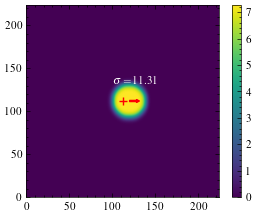

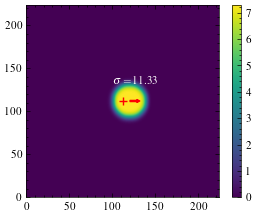

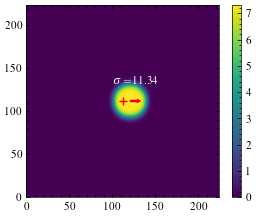

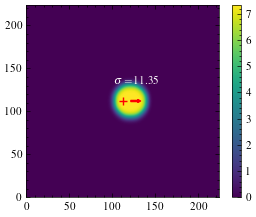

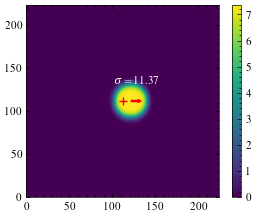

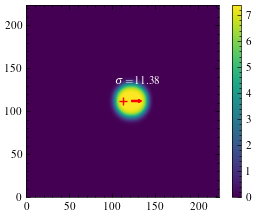

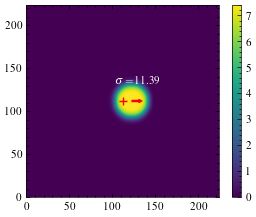

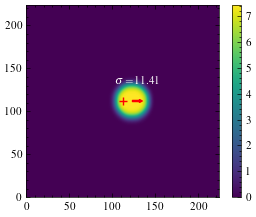

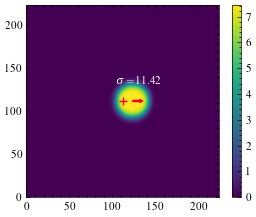

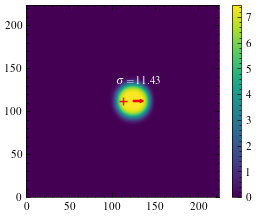

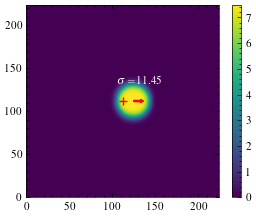

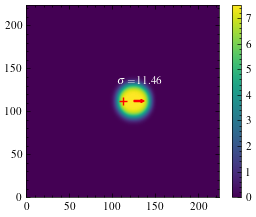

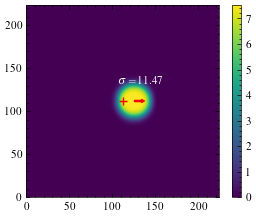

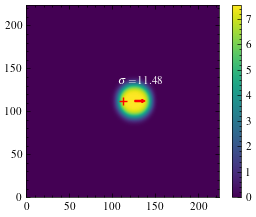

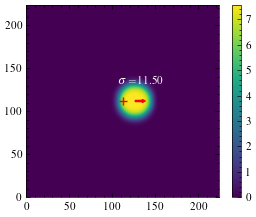

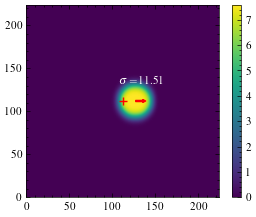

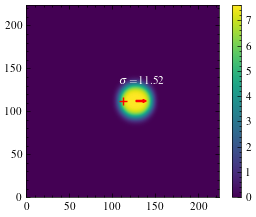

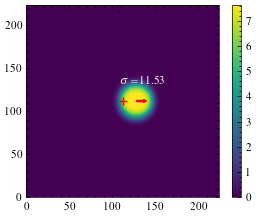

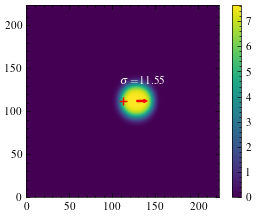

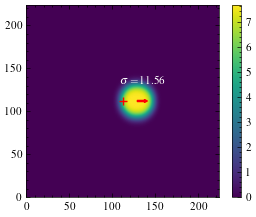

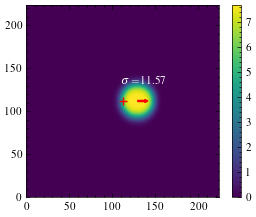

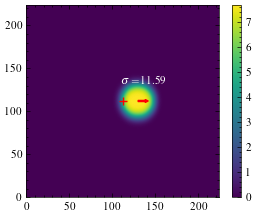

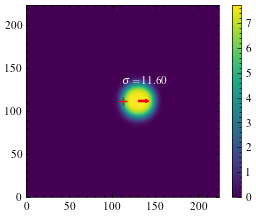

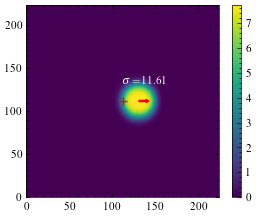

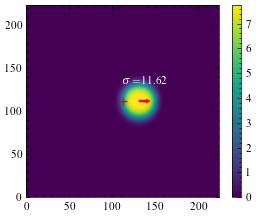

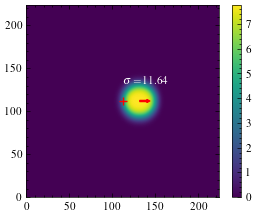

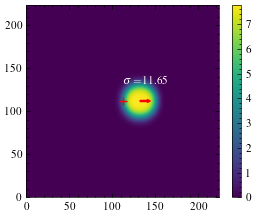

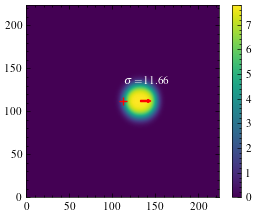

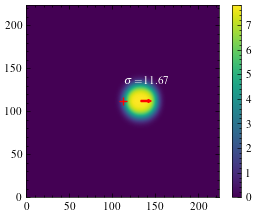

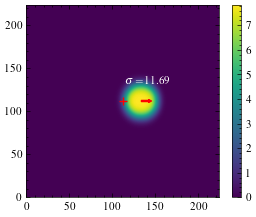

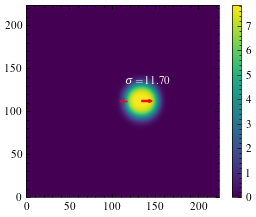

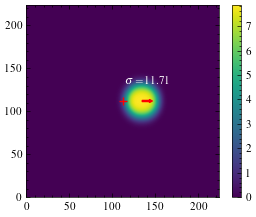

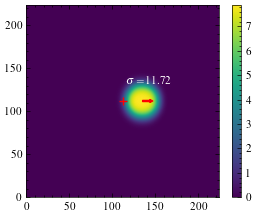

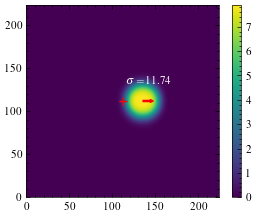

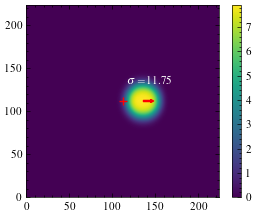

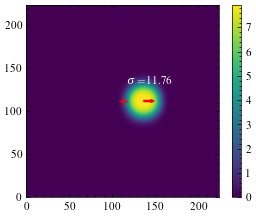

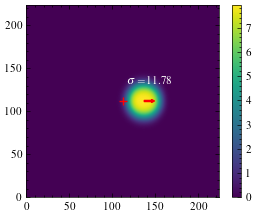

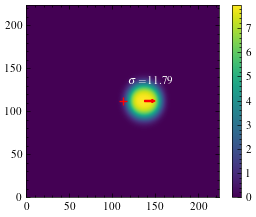

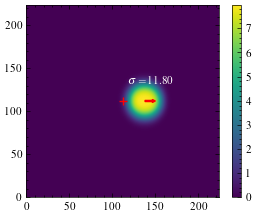

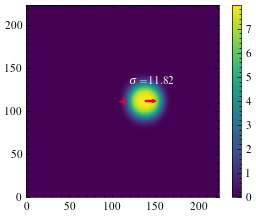

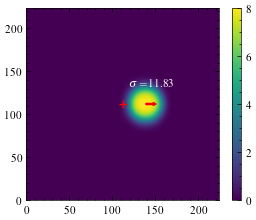

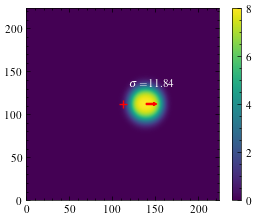

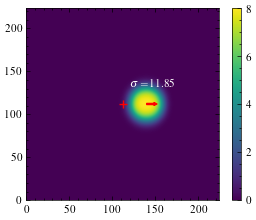

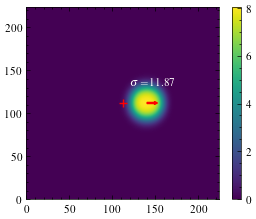

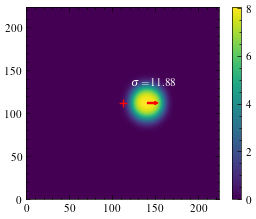

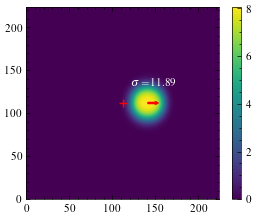

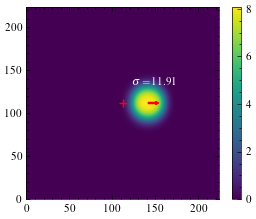

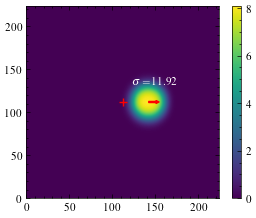

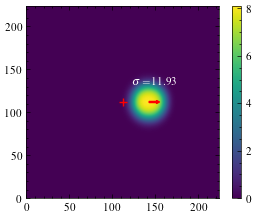

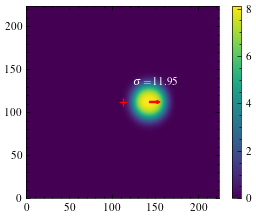

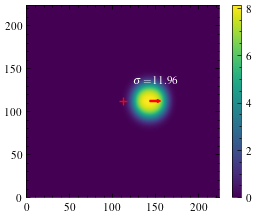

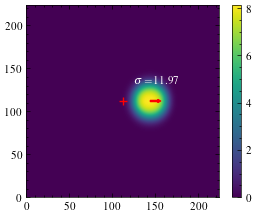

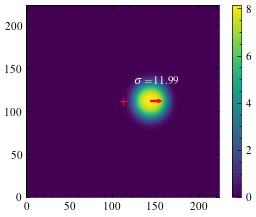

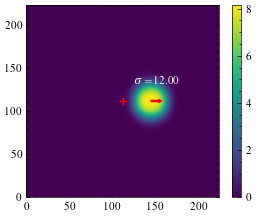

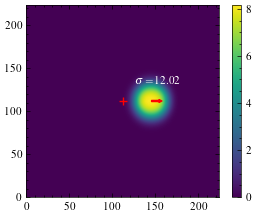

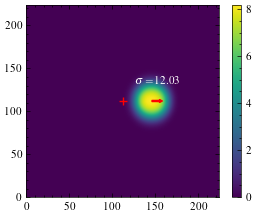

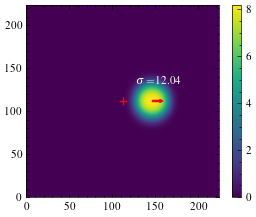

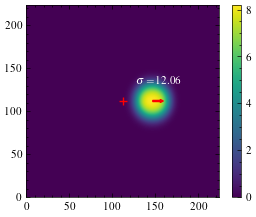

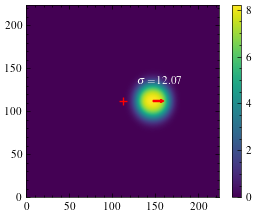

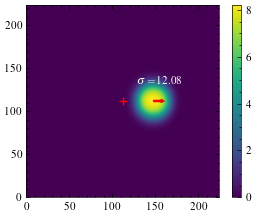

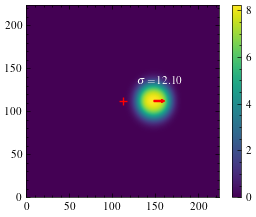

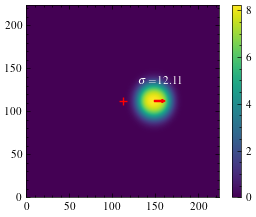

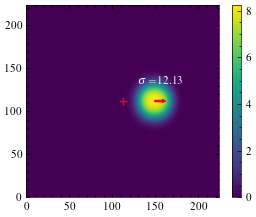

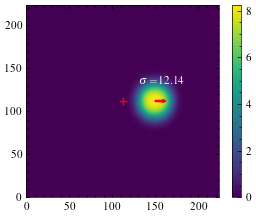

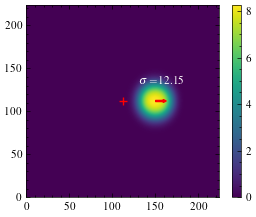

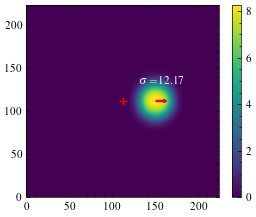

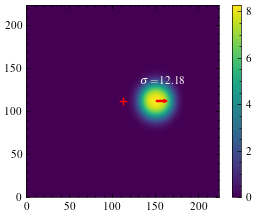

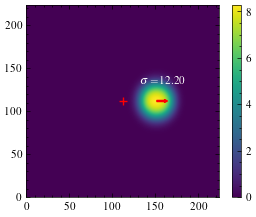

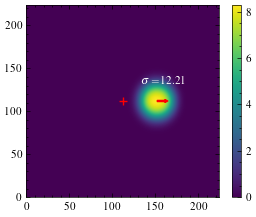

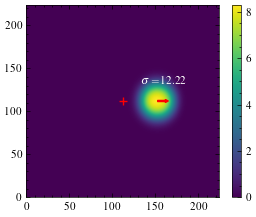

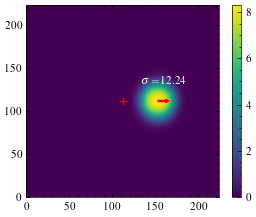

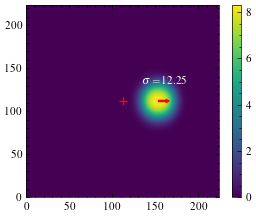

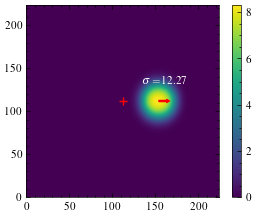

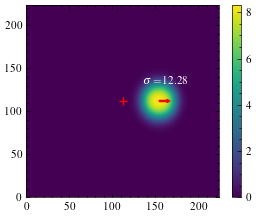

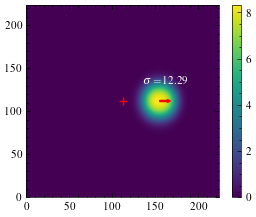

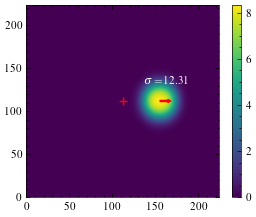

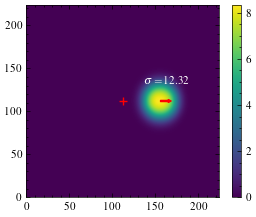

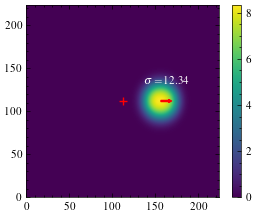

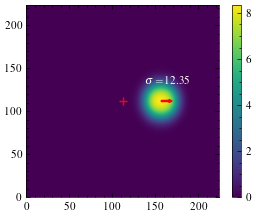

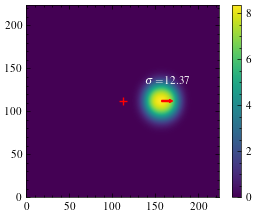

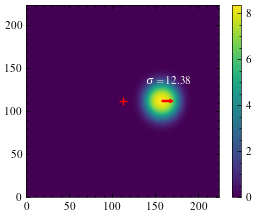

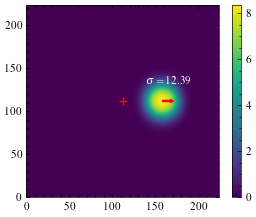

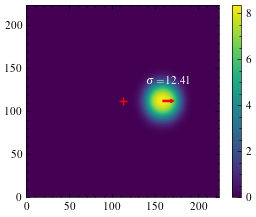

In [8]:
import matplotlib.patches as mpatches

w =tf.cast(filters, dtype=tf.float32)# tf.expand_dims(filters, -1), dtype=tf.float32)
w = tf.transpose(w, perm=(1,0,2,3))
print(w.shape)

x = img


directory = f"figures/hand_DC_grad_mix_unipolar_0.25"
if not os.path.exists(directory):
	os.makedirs(directory)
x = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = filters.shape[-2], axis=-1), dtype=tf.float32) 
for i in range(100):
	print(i)
	fig, ax = plt.subplots()
	print(x.shape)
	x = x/np.std(x)
	vals = x[0, x.shape[1]//2, :, :]
	vals = vals/np.sum(vals)

	print("VALS", np.sum(vals))
	pos = np.expand_dims(np.linspace(-x.shape[1]//2, x.shape[1]//2, x.shape[1]),-1)
	mean = tf.reduce_sum(pos*vals)
	var = tf.reduce_sum(((pos-mean)**2) * vals)
	std = np.sqrt(var)
	print(mean, np.sqrt(var))
	
	#x = tf.repeat(x , repeats = filters.shape[-2], axis=-1)
	print(x.shape)

	im = ax.imshow(np.sum(x[0,:,:,:], axis=-1))
	ax.plot(112, 112, marker = '+', color='red')

	#ax.plot(112+mean, 112, marker = ".", color='black')
	arr =  mpatches.FancyArrowPatch((112.+mean, 112.), (112+mean+std, 112),
							mutation_scale=4, shrinkA=0, shrinkB=0,zorder=10, color="red")
	ax.add_patch(arr)
	
	ax.annotate(r'$\sigma=$'+f"{std:.2f}", (.5, 6), xycoords=arr, ha='center', va='bottom',color='white')
	#ax.arrow(, 112, dx=, dy= 0, color='black')

	ax.set(xlim=(0, 224), ylim=(0, 224))

	fig.colorbar(im, orientation='vertical')
	fig.savefig(directory + f'/{i}.png', dpi=600,  transparent=True, bbox_inches='tight')

	x = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
							padding='SAME') )

(0.0, 224.0)

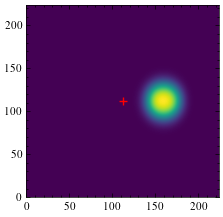

In [9]:
x = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
						padding='SAME') )
	
im = plt.imshow(np.sum(x[0,:,:,:], axis=-1))
plt.plot(112, 112, marker = '+', color='red')
plt.xlim([0, 224])#, ylim=(0, 224))
plt.ylim([0, 224])#, ylim=(0, 224))

#, ylim=(0, 224))

In [10]:
pos[:, x.shape[1]//2, : , :]

IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

In [ ]:
pos

array([-112.        , -110.9955157 , -109.99103139, -108.98654709,
       -107.98206278, -106.97757848, -105.97309417, -104.96860987,
       -103.96412556, -102.95964126, -101.95515695, -100.95067265,
        -99.94618834,  -98.94170404,  -97.93721973,  -96.93273543,
        -95.92825112,  -94.92376682,  -93.91928251,  -92.91479821,
        -91.9103139 ,  -90.9058296 ,  -89.90134529,  -88.89686099,
        -87.89237668,  -86.88789238,  -85.88340807,  -84.87892377,
        -83.87443946,  -82.86995516,  -81.86547085,  -80.86098655,
        -79.85650224,  -78.85201794,  -77.84753363,  -76.84304933,
        -75.83856502,  -74.83408072,  -73.82959641,  -72.82511211,
        -71.8206278 ,  -70.8161435 ,  -69.81165919,  -68.80717489,
        -67.80269058,  -66.79820628,  -65.79372197,  -64.78923767,
        -63.78475336,  -62.78026906,  -61.77578475,  -60.77130045,
        -59.76681614,  -58.76233184,  -57.75784753,  -56.75336323,
        -55.74887892,  -54.74439462,  -53.73991031,  -52.73542

In [ ]:
pos[x.shape[1]//2]

0.5022421524663656